In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

import folium

In [6]:
DATA_PATH = 'data/'

In [122]:
fullDist = pd.read_csv(DATA_PATH+'fullDistance.csv',index_col=0)
fullTime = pd.read_csv(DATA_PATH+'fullTime.csv',index_col=0)
fullTraffic = pd.read_csv(DATA_PATH+'fullTraffic.csv',index_col=0)

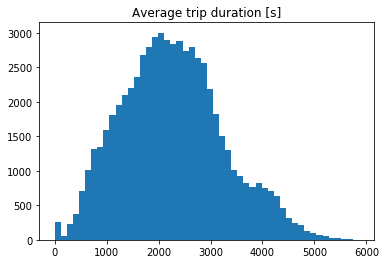

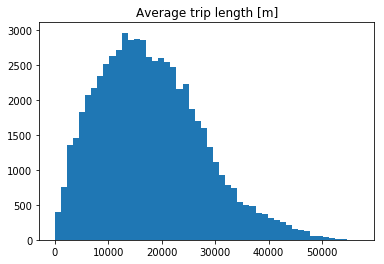

In [123]:
plt.hist(fullTime.values.ravel(),bins=50);
plt.title('Average trip duration [s]');

plt.figure()

plt.hist(fullDist.values.ravel(),bins=50);
plt.title('Average trip length [m]');

## Sparsing the graph with an RBF kernel

In [124]:
def rbf(df,sigma = None,thresh = None):
    
    if sigma == None:
        sigma = 1.5*np.std(df.values.ravel())
        print(sigma)
        
    rbf = np.exp(-np.power(df,2)/(2*sigma**2))
    
    if thresh is not None:
        rbf[rbf<thresh] = 0
    
    return rbf

### Distance

14550.307845721254


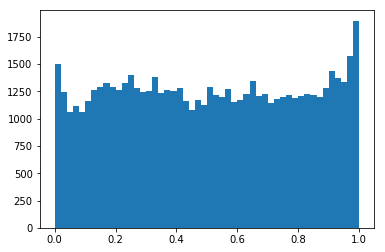

In [125]:
plt.hist(rbf(fullDist).values.ravel(),bins = 50);

In [126]:
gpsData = pd.read_csv(DATA_PATH+'finalGpsMax.csv',index_col = 0)
gpsData.head()

,LocationID,Borough,Zone,lat,lng,Counts
12,13,Manhattan,Battery Park City,40.711579,-74.015844,139993
36,37,Brooklyn,Bushwick South,40.695776,-73.917060,106234
47,48,Manhattan,Clinton East,40.721264,-73.983850,257091
49,50,Manhattan,Clinton West,40.762804,-73.994068,149228
60,61,Brooklyn,Crown Heights North,40.669402,-73.942232,105591


In [127]:
top50 = list(set(gpsData.index.values)-set('99'))
top50.sort()

In [128]:
drop_cols = list(set(fullDist.columns.values) - set(gpsData.index.values.astype(str)))
#manDist = fullDist.iloc[list(gpsData.columns.values)].drop(drop_cols,axis=1)
manDist = fullDist.loc[top50].drop(drop_cols,axis=1).dropna()

/home/manu/anaconda3/envs/data/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


In [132]:
manDist.head()

,12,36,47,49,60,67,78,79,86,89,...,235,236,237,238,245,248,254,255,261,262
LocationID,,,,,,,,,,,,,,,,,,,,,
12,0.0,11000.0,16092.0,7083.0,16421.0,12530.0,17024.0,4793.0,34007.0,11058.0,...,16092.0,9353.0,9353.0,8958.0,24058.0,17732.0,21000.0,7542.0,1115.0,9800.0
36,11000.0,0.0,20665.0,4757.0,20994.0,13016.0,21597.0,8928.0,23769.0,9397.0,...,20665.0,13587.0,13587.0,13531.0,25959.0,22305.0,25466.0,4871.0,11531.0,13291.0
47,16092.0,20665.0,0.0,19879.0,1909.0,27480.0,1212.0,13719.0,38723.0,23861.0,...,2665.0,9313.0,9313.0,8918.0,38112.0,2269.0,5218.0,17519.0,15819.0,9760.0
49,7083.0,4757.0,19879.0,0.0,20208.0,9040.0,20811.0,7179.0,27559.0,5421.0,...,19879.0,12939.0,12939.0,12745.0,21983.0,21519.0,24787.0,4082.0,8049.0,13219.0
60,16421.0,20994.0,1909.0,20208.0,0.0,27809.0,1646.0,14048.0,37867.0,24190.0,...,3909.0,9642.0,9642.0,9247.0,38441.0,1759.0,4814.0,17848.0,16148.0,10089.0


13568.331006909728


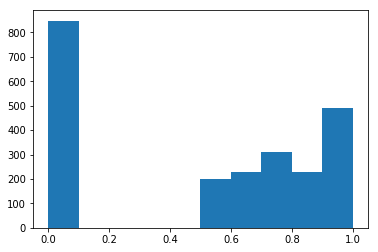

In [134]:
thresh = 0.5
sparsed = rbf(manDist,thresh=thresh)
plt.hist(sparsed.values.ravel());

In [135]:
sparsed = ((sparsed[sparsed!=0]-thresh)*(1/thresh)).fillna(0) #minmax scaling

gpsMax = pd.read_csv(DATA_PATH+'finalGpsMax.csv',index_col=0)
drop = list(set(sparsed.index.values)-set(gpsMax['LocationID']))
sparsed = sparsed.loc[gpsMax['LocationID'].values]

for i,v in enumerate(sparsed.columns.values):
    if int(v) not in gpsMax['LocationID'].values:
        sparsed = sparsed.drop(v,axis=1)
gpsData = gpsMax
sparsed.head()

In [136]:
G = nx.from_numpy_matrix(sparsed.values)

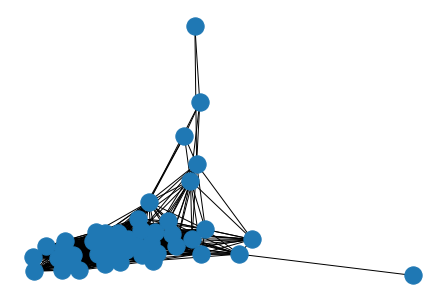

In [137]:
Gc = max(nx.connected_component_subgraphs(G), key=len)
nx.draw(Gc)

In [138]:
#number of edges
print('Nodes: {} , Edges: {}'.format(len(Gc),len(Gc.edges())))

Nodes: 48 , Edges: 752


In [139]:
m = folium.Map(
    location=[40.7, -73.9],
    zoom_start=11,
    tiles='Stamen Terrain'
)

for i in range(len(gpsData)):
    lat = gpsData.iloc[i]['lat']
    lng = gpsData.iloc[i]['lng']
    zone = gpsData.iloc[i]['Zone']
    loc = gpsData.iloc[i]['LocationID']
    counts = gpsData.iloc[i]['Counts']
    
    folium.Marker(
        [lat,lng], 
                  popup='<i> {} </i>'.format(zone),
                  tooltip=zone,
                  icon=folium.Icon(color='red', icon='info-sign')
                 ).add_to(m)


    
for x, y in Gc.edges():
    points = [(gpsData['lat'].iloc[x], gpsData['lng'].iloc[x]),(gpsData['lat'].iloc[y], gpsData['lng'].iloc[y])]
    edge = folium.PolyLine(locations=points, weight=1, color='blue')
    edge.add_to(m)
m

In [140]:
drop_cols = sparsed.columns[list(set(G.nodes()) - set(Gc.nodes()))]
sparsed = sparsed.iloc[list(Gc.nodes())].drop(drop_cols,axis=1)

In [141]:
sparsed.to_csv(DATA_PATH+'sparsedManDist.csv')

# exp

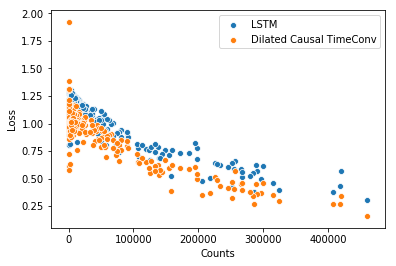

In [187]:
import seaborn as sns

corr = pd.read_csv('losses.txt',header=None)
corr.columns = ['loc','Loss']

occ = pd.read_csv('data/finalGps.csv',index_col=0)
merged1 = pd.merge(corr, occ, how='inner', on=None, left_on='loc', right_on='LocationID',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)


corr = pd.read_csv('losses2.txt',header=None)
corr.columns = ['loc','Loss']

occ = pd.read_csv('data/finalGps.csv',index_col=0)
merged2 = pd.merge(corr, occ, how='inner', on=None, left_on='loc', right_on='LocationID',
         left_index=False, right_index=False, sort=True,
         suffixes=('_x', '_y'), copy=True, indicator=False,
         validate=None)
#plt.scatter(merged.Counts,merged.Loss)
#sns.regplot(merged.Counts,merged.Loss,order=2)
sns.scatterplot(merged1.Counts,merged1.Loss,label='LSTM')
sns.scatterplot(merged2.Counts,merged2.Loss,label='Dilated Causal TimeConv')
plt.legend()

In [188]:
merged2.corr()

,loc,Loss,LocationID,lat,lng,Counts
loc,1.000000,-0.204716,1.000000,0.116741,-0.054855,0.143378
Loss,-0.204716,1.000000,-0.204716,-0.060475,0.297729,-0.878696
LocationID,1.000000,-0.204716,1.000000,0.116741,-0.054855,0.143378
lat,0.116741,-0.060475,0.116741,1.000000,0.326469,0.044210
lng,-0.054855,0.297729,-0.054855,0.326469,1.000000,-0.316183
Counts,0.143378,-0.878696,0.143378,0.044210,-0.316183,1.000000


In [198]:
merged1.sort_values('Counts',ascending=False).head(48).Loss.mean()

0.6235268251117109

### Time

In [ ]:
plt.hist(rbf(fullTime).values.ravel(),bins = 50);

In [ ]:
sparsed = rbf(fullTime,thresh=0.7)
G = nx.from_numpy_matrix(sparsed.values)
Gc = max(nx.connected_component_subgraphs(G), key=len)
#number of edges
print('Nodes: {} , Edges: {}'.format(len(Gc),len(Gc.edges())))

In [ ]:
drop_cols = sparsed.columns[list(set(G.nodes()) - set(Gc.nodes()))]
sparsed = sparsed.iloc[list(Gc.nodes())].drop(drop_cols,axis=1)

In [ ]:
sparsed.to_csv(DATA_PATH+'sparsedTime.csv')

In [ ]:
plt.hist(rbf(fullTraffic).values.ravel(),bins = 50);

In [ ]:
sparsed = rbf(fullTraffic,thresh=0.7)
G = nx.from_numpy_matrix(sparsed.values)
Gc = max(nx.connected_component_subgraphs(G), key=len)
#number of edges
print('Nodes: {} , Edges: {}'.format(len(Gc),len(Gc.edges())))

In [ ]:
drop_cols = sparsed.columns[list(set(G.nodes()) - set(Gc.nodes()))]
sparsed = sparsed.iloc[list(Gc.nodes())].drop(drop_cols,axis=1)

In [ ]:
sparsed.to_csv(DATA_PATH+'sparsedTraffic.csv')

## Sparse the graph by boroughs

Done in previous notebook